### Introduction

You might have already tried to calculate the power spectrum using pacakges like `nbodykit`. But do you know what actually happened when you were running codes like `nbodykit.algorithms.fftpower.FFTPower(...)`? If not, no worries! Since that is exactly what you will be learning from this notebook.

### Goal:
* Understand Fourier Transformations
* Learn to calculate Power Spectrum
* Learn to calculate Potential and Force-field
* Learn how to get from linear field to Zel'dovich

In [23]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt

import sys
sys.path.append("../../../")

import sheet_unfolding.sim as sim

from matplotlib.colors import LogNorm

## Calculate the Power Spectrum

The definition for power spectrum is really simple
\begin{align}
  P(k) = \langle |\delta(|\vec{k}|)|^2 \rangle,
\end{align}
where $\delta(\vec{k})$ is the overdensity field in Fourier space, i.e. the Fourier transform of $\delta(\vec{x})$. In simulations, $\delta(\vec{x})$ is usually obtained based on some grids, every grid cell corresponds to a coordinate $\vec{x_i}$ and the overdensity at the coordinate is $\delta(\vec{x_i})$. Similarly, when you transformed it into Fourier space, every grid cell corresponds to a wavenumber $\vec{k_i}$ and the overdensity at the wavenumber is $\delta(\vec{k_i})$. Therefore, to get $P(k)$, you need to 
* Get the $\delta(\vec{x})$ at $a=1$ using `sim.ic.IC2DCosmo.get_delta()`,
* Fourier transform $\delta(\vec{x})$ and get $\delta(\vec{k})$ using `np.fft.fft2()`,
* Fourier transform the coordinate of the grids $\vec{x}$ to get $\vec{k}$ (this can be tricky, a code is provided in `get_kmesh()`),
* Get the the squared modulus of $\delta(\vec{k})$ and the modulus of $\vec{k}$ at every grid cells.
* Make proper bins for $k$, and calculate the average value of $|\delta(|\vec{k}|)|^2$ in each k bin as the $P(k)$ in the bin.
* Plot your results.
* Compare your results with the one derived from `sim.ic.power_eisenstein_smoothed_2d`. Does they overlap with each other? Try different smoothing radius for the initial condition setting, what does the smoothing do to the power spectrum? Can you explain why it behaves in this way?

**Normalisations**

1. Notice that the discrete Fourier transform (DFT) uses a different normalisation. To convert them you need
\begin{align}
  \delta_k = \delta_{k, DFT} \frac{\sqrt{L}^d}{N^d}
\end{align}
where $d = 2$ is the dimension, $L$ is the side length of your simulation box, and $N$ is the number of grids on each side.

2. To compare your power spectrum with the one from `sim.ic.power_eisenstein_smoothed_2d`, the latter need to be converted into the same units by multiplying the return of `sim.ic.power_eisenstein_smoothed_2d` by $f^2_{\mathrm{norm}}$, where $f_{\mathrm{norm}}=$`0.8/sim.ic.get_sigmaR(8.)`.

You can also try to do the same calculation for the dimensionless power spectrum

\begin{align}
  D(k) = P(k) k^2 / (2 \pi).
\end{align}

(Note that this relation (2D) is different in 3 dimensions).

In [14]:
def get_kmesh(npix, L, real=False):
    """ construct a uniform mesh of kvectors (for usage with np.fft.fftn)
 
    Parameters:
    ----------
    npix : sequence of integer
        Number of pixels in each dimension
    L :  float
        Size of the domain (in real space) - typically the boxsize
    real : bool
        Set to true for usage with np.fft.rfftn

    Returns:
    ----------
    knd : (npix[0], npix[1], ..., len(npix)) array of k-vectors

    Example:
    ----------
    k = get_kmesh((128,128,128), 10., real=False)
    => (128,128,128,3) array
    """

    ndim = len(npix)

    L = np.ones_like(npix) * L

    k1d = []
    for i in range(0, ndim):
        if (i == ndim-1) & real:  # last dim can have different shape in real fft
            k1d.append(np.fft.fftfreq(npix[i])[0:(npix[i]//2)+1] * (2*np.pi * npix[i]) / L[i])
        else:
            k1d.append(np.fft.fftfreq(npix[i]) * (2*np.pi * npix[i]) / L[i])

    knd  = np.array(np.meshgrid(*k1d, indexing='ij')).astype("f4")
    knd  = np.rollaxis(knd, 0, ndim+1)  # bring into shape [npix,npix,...,ndim]

    return knd

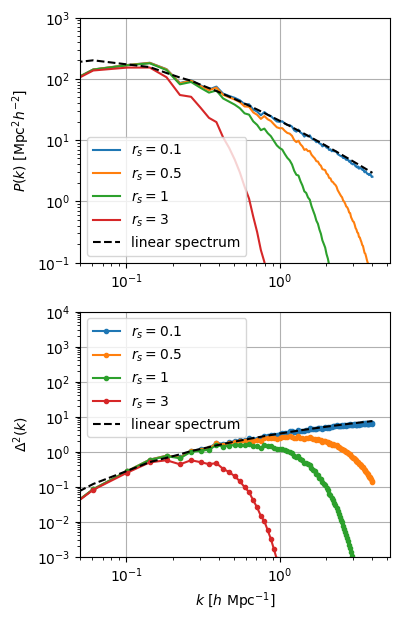

In [49]:
L = 400.

bins = np.linspace(0., 512*np.pi/L,100)
ki = 0.5*(bins[1:] + bins[:-1])

fig, axs = plt.subplots(2,1, figsize=(4,7),dpi=100)

for rs in (0.1, 0.5,1., 3.):
    myic = sim.ic.IC2DCosmo(512, L=L, rs=rs, Omega_m=1.)
    delta = myic.get_delta(a=1.)
    
    deltak =  np.fft.fft2(delta) / np.prod(delta.shape) * L
    
    kvec = get_kmesh((512,512), L)
    kabs = np.sqrt(np.sum(kvec**2, axis=-1))
    
    # Fill in code to calculate and plot power spectrum here: 
    # You'll need to average modes in each k-bin <---
    
    sum_deltak2,b = np.histogram(kabs, bins=bins, weights=np.abs(deltak)**2)
    N,b = np.histogram(kabs, bins=bins)
    pk = sum_deltak2 / N
    axs[0].loglog(ki, pk, label=r"$r_s = %g$" % rs)    
    axs[1].loglog(ki, pk * ki**2 / (2.*np.pi), label=r"$r_s = %g$" % rs, marker=".")
    
    # --->
    
norm = 0.8/sim.ic.get_sigmaR(8.)
axs[0].loglog(ki, norm**2*sim.ic.power_eisenstein_smoothed_2d(ki, dimless=False), ls="dashed", color="black", label="linear spectrum")
axs[1].loglog(ki, norm**2*sim.ic.power_eisenstein_smoothed_2d(ki, dimless=True), ls="dashed", color="black", label="linear spectrum")

axs[0].set_ylim(1e-1,1e3)
axs[1].set_ylim(1e-3,1e4)

for ax in axs:
    ax.grid()
    ax.legend()
    ax.set_xlim(5e-2, None)
axs[1].set_xlabel(r"$k$ [$h$ Mpc$^{-1}$]")
axs[0].set_ylabel(r"$P(k)$ [Mpc$^{2} h^{-2}$]")
axs[1].set_ylabel(r"$\Delta^2 (k)$")

plt.savefig("img/power_spectrum.png", bbox_inches="tight")

## Calculate the Potential

Now you should have mastered how to get the power spectrum given real-space overdensity using Fourier transform. There are many other pros of doing things in Fourier space, one of which is that differenciation in real space becomes simple multiplication in Fourier space. In this subsection, we will explore how to calculate gravity in $N$-body simulations quickly by calculating the Poisson's equation in Fourier space.

Poisson's equation and the acceleration equation in real space are
\begin{align}
   \nabla^2 \phi = 4 \pi G\bar{\rho} \delta \\
            \vec{a} = - \nabla \phi.
\end{align}
In Fourier Space they become
\begin{align}
   \phi_k = - \frac{4 \pi G \bar{\rho}\delta_k}{k^2} \\
            \vec{a_k} = - i \vec{k} \phi_k
\end{align}

that means I can calculate $\phi$ and $a$ in real space by doing:
\begin{align}
   \phi = -4 \pi G\bar{\rho} \cdot \rm{IFFT}\left(\frac{\rm{FFT}(\delta)}{k^2}\right)\\
   \vec{a} = 4 \pi G \bar{\rho}\cdot\rm{IFFT}\left(  \frac{i \vec{k}\cdot\rm{FFT}(\delta)}{k^2}\right)
\end{align}

We can also calculate the acceleration (along the x direction for example) from the finite diffenciation:
$\begin{align}
   a_x \approx \frac{\phi(x+dx,y) - \phi(x-dx,y)}{2 dx}
\end{align}$


### Task:
* Calculate Potential Field in real space
* Calculate Acceleration Field (just the x-component) in real space
    - through Fourier Space
    - through finite differences on $\phi$

### Some Notes:
Just use $r_s = 0.1$ for this task. We will set all the constants to 1 for simplicity. You can set phi_k[0,0] explicitly to 0 to avoid problems with zero divisions. IFFT will return complex numbers with complex part = 0, but you can just cast them to real ones with np.real. Because of the numpy broadcasting rules (https://numpy.org/doc/stable/user/basics.broadcasting.html) you may have to do something like this to multiply a field by a vector field: phik[...,np.newaxis] * kvec

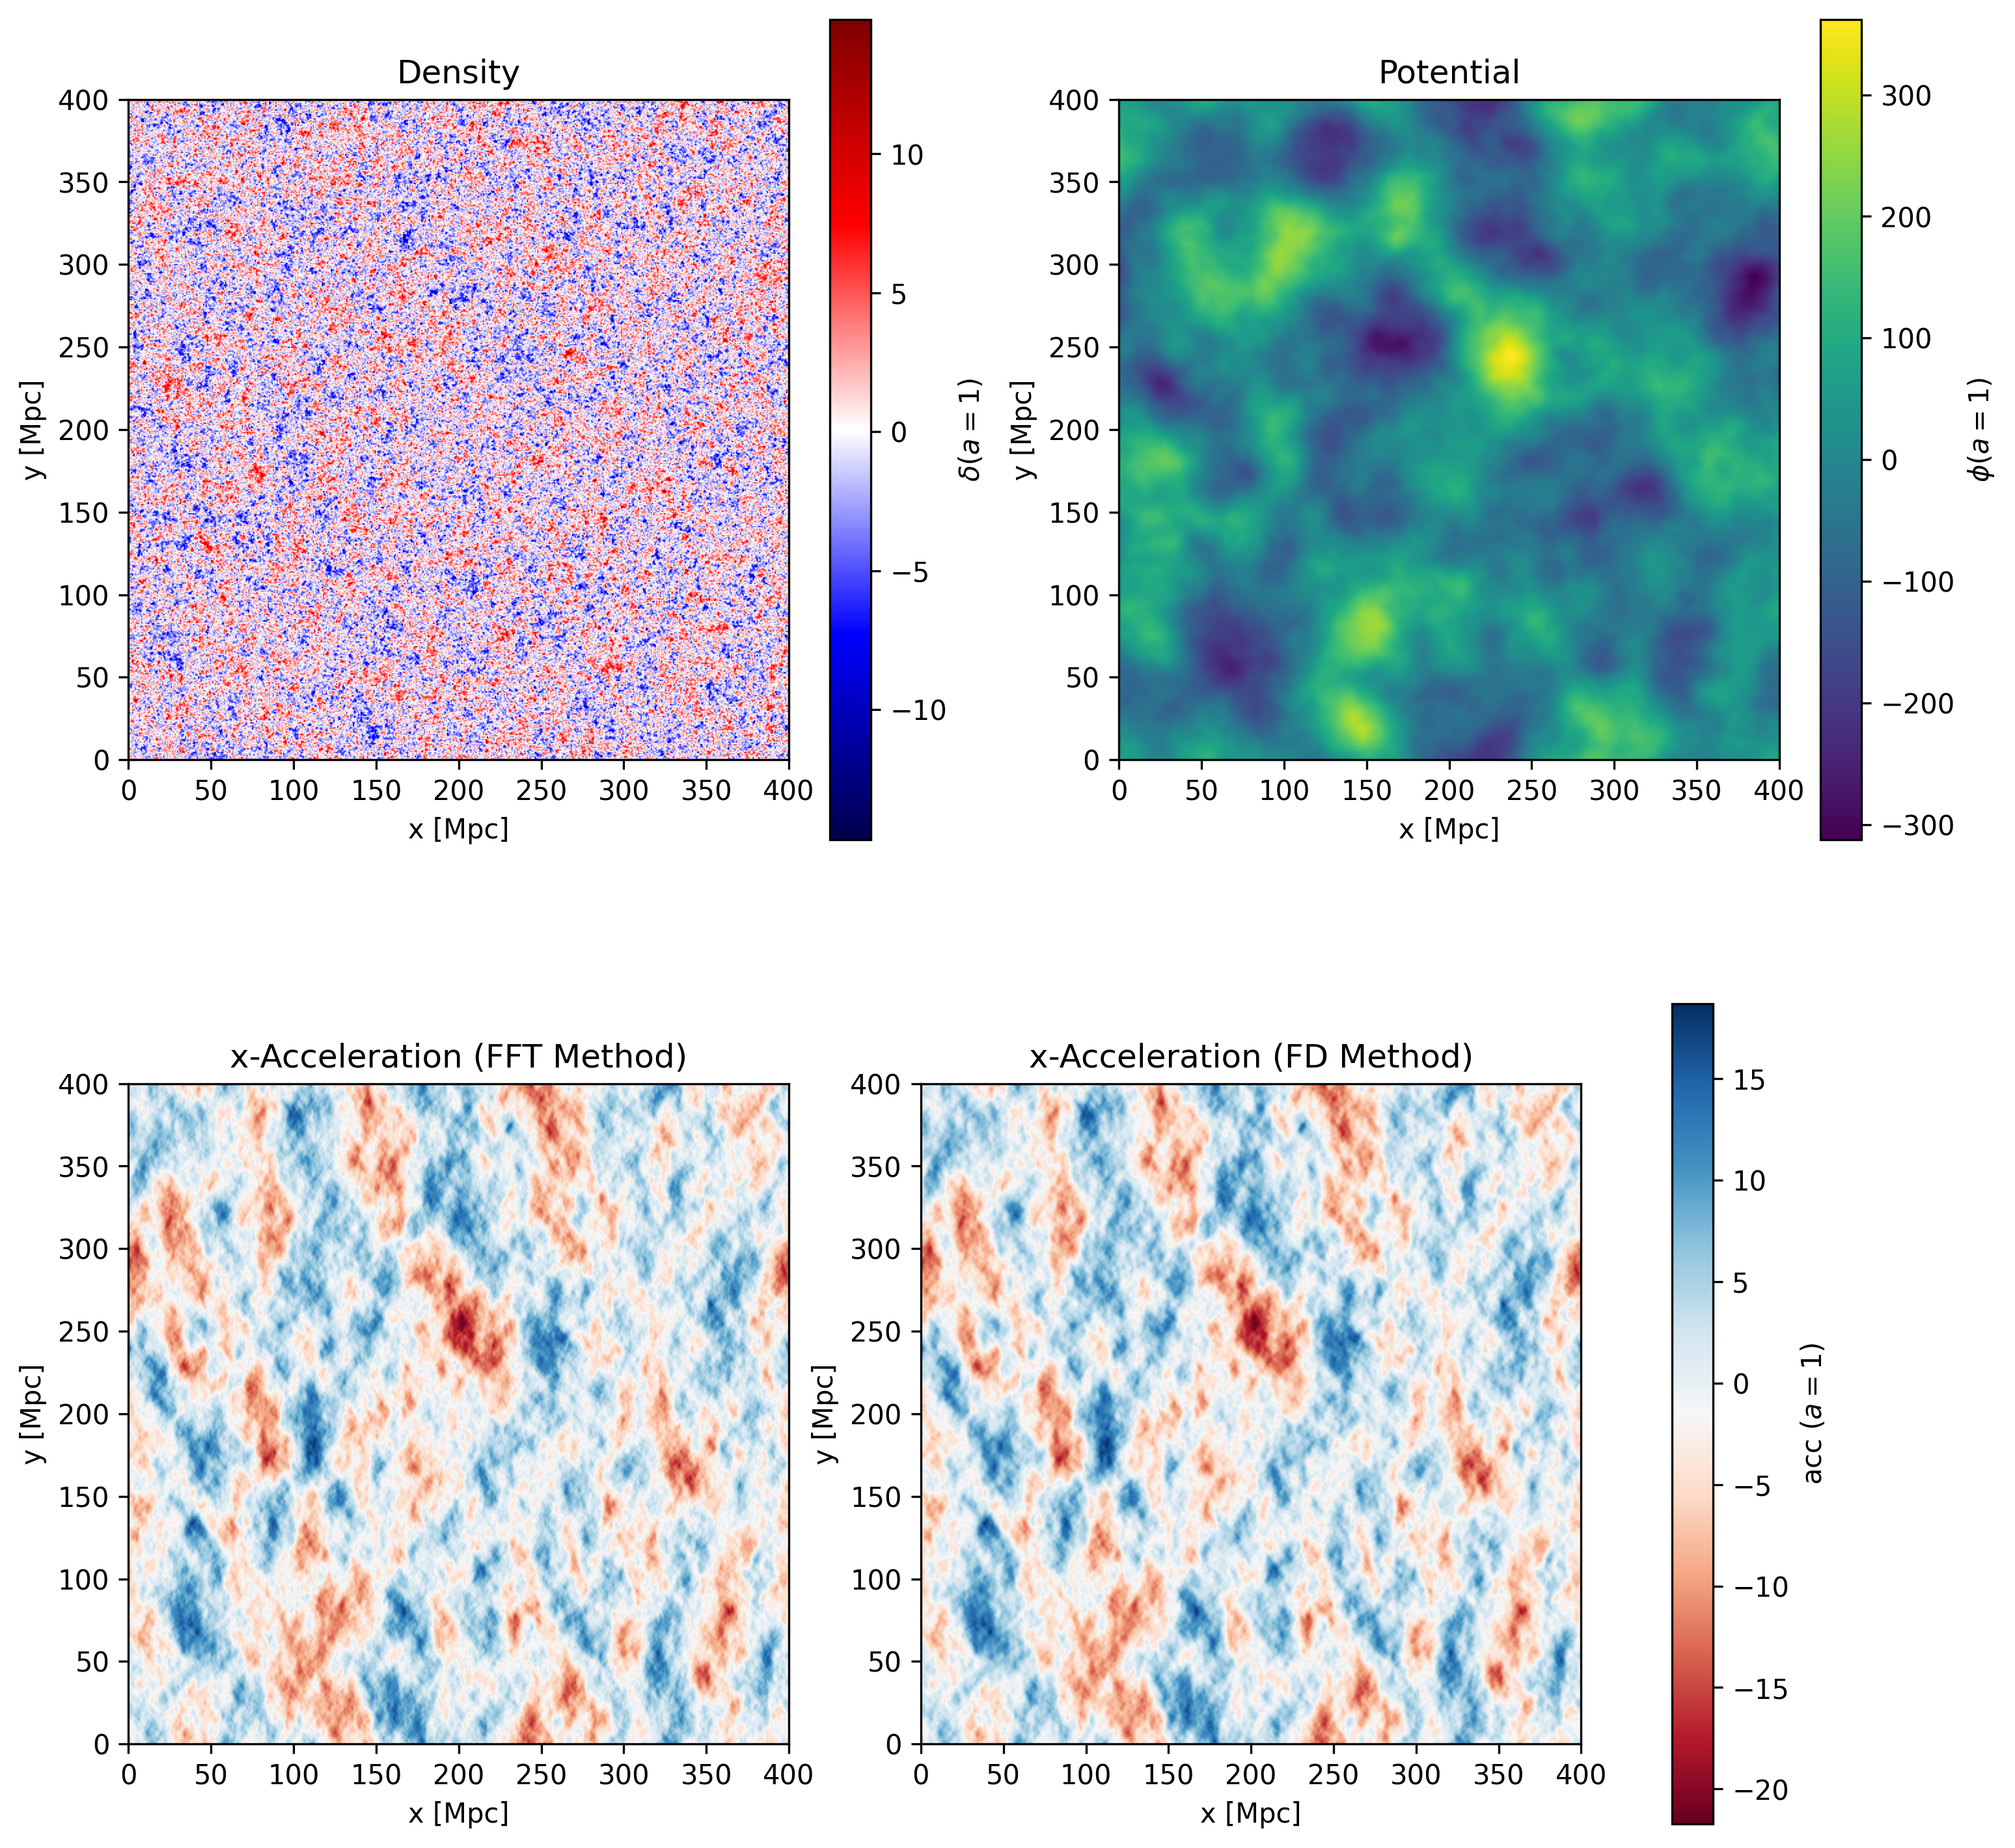

In [53]:
L = 400.
kvec = get_kmesh((512,512), L)
myic = sim.ic.IC2DCosmo(512, L=L, rs=0.1, vec3d=True, Omega_m=1.)
delta = myic.get_delta(a=1)

# Fill in code here
delta_k = np.fft.fft2(delta)

phi_k = -delta_k / np.clip(kabs, 1e-20, None)**2
phi_k[0,0] = 0.
phi = np.real(np.fft.ifft2(phi_k))

acc_k = -1j * kvec * phi_k[...,np.newaxis]
acc = np.real(np.fft.ifft2(acc_k, axes=(0,1)))

accx_finitediff = -((np.roll(phi, -1, axis=0) - np.roll(phi, 1, axis=0)) / (2.*(L/512.)))
# accy_finitediff = -((np.roll(phi, -1, axis=1) - np.roll(phi, 1, axis=1)) / (2.*(L/512.)))

fig, axs = plt.subplots(2, 2, figsize=(12,12),dpi=300)

im = axs[0,0].imshow(delta.T, origin="lower", cmap="seismic", extent=[0,L,0,L])
plt.colorbar(im, ax=axs[0,0], label=r"$\delta (a = 1)$")
axs[0,0].set_title("Density")

im = axs[0,1].imshow(phi.T, origin="lower", cmap="viridis", extent=[0,L,0,L])
plt.colorbar(im, ax=axs[0,1],  label=r"$\phi (a = 1)$")
axs[0,1].set_title("Potential")

im = axs[1,0].imshow(acc[...,0].T, origin="lower", cmap="RdBu", extent=[0,L,0,L])
im = axs[1,1].imshow(accx_finitediff.T, origin="lower", cmap="RdBu", extent=[0,L,0,L])


axs[1,0].set_title(r"x-Acceleration (FFT Method)")
axs[1,1].set_title(r"x-Acceleration (FD Method)")

# im = axs[1,1].imshow(acc[...,1].T, origin="lower", cmap="RdBu", vmin=-0.5, vmax=0.5, extent=[0,L,0,L])
# im = axs[2,1].imshow(accy_finitediff.T, origin="lower", cmap="RdBu", vmin=-0.5, vmax=0.5, extent=[0,L,0,L])
plt.colorbar(im, ax=axs[1:2,:], orientation="vertical", label=r"acc $(a = 1)$")
# axs[2,0].set_title(r"x-Acceleration (FD Method)")
# axs[2,1].set_title(r"y-Acceleration (FD Method)")

for ax in axs.flat:
    ax.set_xlabel("x [Mpc]")
    ax.set_ylabel("y [Mpc]")
    
plt.savefig("img/force_calculation.png", bbox_inches="tight")

## Zel'dovich approximation

Now you should also be able to implement the Zel'dovich approximation yourself (given the linear overdensity) with all the skills you mastered in this notebook. 

You can have a look at the the source codes of `sim.ic.IC2DCosmo.get_x()` for an example of this.